In [20]:
# read sentiment score from txt
path = "../data/Data_Set_S1.txt"
with open(path, "r") as f:
    sentiment_score = f.read().strip()
print(f"Sentiment score: {sentiment_score}")

Sentiment score: labMIT-1.0.txt
language assessment by Mechanical Turk 1.0

word	happiness_rank	happiness_average	happiness_standard_deviation	twitter_rank	google_rank	nyt_rank	lyrics_rank
laughter	1	8.50	0.9313	3600	--	--	1728
happiness	2	8.44	0.9723	1853	2458	--	1230
love	3	8.42	1.1082	25	317	328	23
happy	4	8.30	0.9949	65	1372	1313	375
laughed	5	8.26	1.1572	3334	3542	--	2332
laugh	6	8.22	1.3746	1002	3998	4488	647
laughing	7	8.20	1.1066	1579	--	--	1122
excellent	8	8.18	1.1008	1496	1756	3155	--
laughs	9	8.18	1.1551	3554	--	--	2856
joy	10	8.16	1.0568	988	2336	2723	809
successful	11	8.16	1.0759	2176	1198	1565	--
win	12	8.12	1.0812	154	3031	776	694
rainbow	13	8.10	0.9949	2726	--	--	1723
smile	14	8.10	1.0152	925	2666	2898	349
won	15	8.10	1.2164	810	1167	439	1493
pleasure	16	8.08	0.9655	1497	1526	4253	1398
smiled	17	8.08	1.0660	--	3537	--	2248
rainbows	18	8.06	1.3603	--	--	--	4216
winning	19	8.04	1.0490	1876	--	1426	3646
celebration	20	8.02	1.5318	3306	--	2762	4070
enjoyed	21	8.02	1.5318	15

In [21]:
import os
import io
import numpy as np
import requests
import pandas as pd

# Fetch sentimantal scores from dataset
local_sentiment_data = "data/Data_Set_S1.txt"
raw_sentiment_url = f"https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/{local_sentiment_data}"

if os.path.exists(local_sentiment_data):
    df = pd.read_csv(local_sentiment_data, sep="\t", skiprows=2, header=0)
else:
    r = requests.get(raw_sentiment_url, timeout=30)
    r.raise_for_status()
    with io.StringIO(r.text) as fh:
        df = pd.read_csv(fh, sep="\t", skiprows=2, header=0)

df["word"] = df["word"].astype("string")
for col in ["twitter_rank", "google_rank", "nyt_rank", "lyrics_rank"]:
    df[col] = df[col].replace("--", np.nan)
    df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

df.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,<NA>,<NA>,1728
1,happiness,2,8.44,0.9723,1853,2458,<NA>,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,<NA>,2332


In [22]:
word_to_happiness_avg = dict(zip(df["word"], df["happiness_average"]))


def sentiment_score(text: str):
    tokens_lower = text.lower().split()
    scores = [
        word_to_happiness_avg[token]
        for token in tokens_lower
        if token in word_to_happiness_avg
    ]
    if scores:
        return sum(scores) / len(scores)
    return None


print("Sentiment dataset statistics:")
print(f"Total words with sentiment scores: {len(word_to_happiness_avg)}")
print(f"Dataset min sentiment score: {min(word_to_happiness_avg.values())}")
print(f"Dataset max sentiment score: {max(word_to_happiness_avg.values())}")
print(
    f"Dataset mean sentiment score: {np.mean(list(word_to_happiness_avg.values())):.4f}"
)
print(
    "Dataset percentiles (25%, Median, 75%):",
    np.percentile(list(word_to_happiness_avg.values()), [25, 50, 75]),
)

Sentiment dataset statistics:
Total words with sentiment scores: 10222
Dataset min sentiment score: 1.3
Dataset max sentiment score: 8.5
Dataset mean sentiment score: 5.3752
Dataset percentiles (25%, Median, 75%): [4.9  5.44 6.02]


In [23]:
from bs4 import BeautifulSoup
import re
import json
from pathlib import Path

# Set up data directory
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

In [24]:
# Setup scripts dictionary
scripts = {}
for movie in ["A New Hope", "The Empire Strikes Back", "Return of the Jedi"]:
    script_file = DATA_DIR / f"html/Star-Wars-{movie.replace(' ', '-')}.html"
    with open(script_file, "r", encoding="utf-8", errors="replace") as f:
        scripts[movie] = f.read()

In [25]:
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already present
try:
    stop_words = set(stopwords.words("english"))
except:  # noqa: E722
    nltk.download("stopwords")
    stop_words = set(stopwords.words("english"))


def fetch_script_from_file(file_path):
    """Load a Star Wars script from local HTML file"""
    print(f"Loading: {file_path}")
    with open(file_path, "r", encoding="utf-8", errors="replace") as f:
        return f.read()


def is_scene_description(line: str) -> bool:
    """
    Detect if a line is a scene description rather than actual dialogue.
    """
    line_stripped = line.strip()
    line_lower = line_stripped.lower()

    # Skip very short lines - likely actual dialogue
    if len(line_lower) < 5:
        return False

    # Strong indicators of scene description
    strong_indicators = [
        "cut to",
        "fade in",
        "fade out",
        "dissolve",
        "pan ",
        "angle on",
        "closeup",
        "close-up",
        "wide shot",
        "ext ",
        "int ",
        "we see",
        "we hear",
        "camera",
        "the screen",
        "offscreen",
        "o.s.",
        "v.o.",
    ]

    if any(indicator in line_lower for indicator in strong_indicators):
        return True

    # Pattern: Line starts with adverb + comma + "he/she/they"
    # e.g., "Nervously, he looks around"
    if re.match(r"^[A-Z][a-z]+ly,\s+(he|she|they|it)\s+", line_stripped):
        return True

    # Pattern: Capitalized Name + action verb (catches "Biggs takes...", "Luke jumps...")
    # This is a key pattern for scene descriptions
    action_verbs = (
        "takes|took|gives|gave|has|had|sees|saw|looks|looked|turns|turned|"
        "walks|walked|runs|ran|grabs|grabbed|holds|held|throws|threw|pops|popped|"
        "jumps|jumped|stands|stood|sits|sat|moves|moved|rushes|rushed|"
        "approaches|approached|enters|entered|exits|exited|opens|opened|"
        "closes|closed|pulls|pulled|pushes|pushed|reaches|reached|fires|fired|"
        "ignites|ignited|swings|swung|blocks|blocked|screams|screamed|"
        "nods|nodded|shakes|shook|starts|started|begins|began|continues|continued"
    )

    if re.match(rf"^[A-Z][a-z]+\s+({action_verbs})\b", line_stripped):
        return True

    # Pattern: "The [noun]..." at start - very common for descriptions
    if re.match(r"^The\s+[a-z]", line_stripped):
        return True

    # Pattern: "A/An [noun]..." at start
    if re.match(r"^An?\s+[a-z]", line_stripped):
        return True

    # Pattern: "He/She/They/It + verb" at start of line
    if re.match(
        r"^(He|She|They|It)\s+(is|are|was|were|has|have|had|takes|gives|sees|looks|turns|walks|runs|grabs|holds|throws|jumps|stands|sits|moves|rushes|approaches|enters|exits|opens|closes|pulls|pushes|reaches|fires|ignites|swings|blocks|screams|nods|shakes|starts|begins|continues)\b",
        line_stripped,
    ):
        return True

    # Pattern: "His/Her/Their + noun" at start
    if re.match(r"^(His|Her|Their|Its)\s+", line_stripped):
        return True

    # Pattern: Lines containing "as [Name] [verbs]" - mid-sentence descriptions
    if re.search(
        r"\bas\s+[A-Z][a-z]+\s+(takes|gives|looks|turns|walks|runs|jumps|grabs)\b",
        line_stripped,
    ):
        return True

    # Pattern: Contains third-person narrative phrases (be conservative to avoid false positives)
    narrative_phrases = [
        r"\bstrain to (see|hear)\b",
        r"\ban air of\b",
        r"\bgives way to\b",
        r"\bthrough the binoculars\b",
        r"\bwith the naked eye\b",
    ]

    for phrase in narrative_phrases:
        if re.search(phrase, line_lower):
            return True

    # Pattern: Multiple character names in one line (describing interaction)
    char_names = [
        "luke",
        "han",
        "leia",
        "vader",
        "chewie",
        "lando",
        "yoda",
        "biggs",
        "wedge",
    ]
    name_count = sum(1 for name in char_names if name in line_lower)
    if name_count >= 2:
        return True

    # Pattern: Ends with stage direction indicators
    if re.search(
        r"\b(behind (him|her|them)|in front of (him|her|them)|next to (him|her|them))\.?$",
        line_lower,
    ):
        return True

    return False


def extract_scenes_and_characters(html_content):
    """Extract scene headings and character names from script HTML"""
    soup = BeautifulSoup(html_content, "html.parser")

    script_table = soup.find("td", class_="scrtext")
    if not script_table:
        print("Warning: Could not find scrtext table in HTML")
        return [], {}, {}, {}, {}

    pre_tag = script_table.find("pre")
    if not pre_tag:
        print("Warning: Could not find pre tag in script table")
        return [], {}, {}, {}, {}

    script_text = pre_tag.get_text()
    lines = script_text.split("\n")

    scenes = []
    location_dialogues = {}
    character_dialogues = {}

    current_scene = {"location": None, "characters": set(), "content": []}
    current_location = None
    current_speaking_character = None
    scene_started = False

    for line in lines:
        line_stripped = line.strip()

        if not line_stripped:
            continue

        # Detect scene headings
        is_scene_heading = False
        if re.match(r"^[0-9]+\s+[A-Z]", line_stripped):
            is_scene_heading = True
            scene_started = True
        elif re.match(r"^(INT|EXT)\.\s+", line_stripped):
            is_scene_heading = True
            scene_started = True

        if is_scene_heading:
            if current_scene["location"] is not None:
                scenes.append(current_scene)

            current_location = line_stripped
            current_speaking_character = None
            current_scene = {
                "location": current_location,
                "characters": set(),
                "content": [],
            }

            if current_location not in location_dialogues:
                location_dialogues[current_location] = []

        # Detect character names - all caps
        elif (
            scene_started
            and re.match(r"^[A-Z][A-Z\s\-\']*$", line_stripped)
            and len(line_stripped) > 1
            and len(line_stripped) < 50
        ):
            char_name = line_stripped.strip()
            if char_name and char_name not in [
                "FADE IN:",
                "FADE OUT:",
                "THE END",
                "CREDITS",
                "TO BE CONTINUED",
                "CUT TO:",
                "DISSOLVE TO:",
                "CONTINUED:",
            ]:
                current_speaking_character = char_name
                current_scene["characters"].add(char_name)
                current_scene["content"].append(("CHARACTER", char_name))

                if char_name not in character_dialogues:
                    character_dialogues[char_name] = []

        # Handle dialogue and action lines
        else:
            if scene_started:
                # Skip pure stage directions in parentheses
                if line_stripped.startswith("(") and line_stripped.endswith(")"):
                    current_scene["content"].append(("STAGE_DIRECTION", line_stripped))
                    continue

                # Check if this is a scene description
                if is_scene_description(line_stripped):
                    current_scene["content"].append(
                        ("SCENE_DESCRIPTION", line_stripped)
                    )

                    if current_location:
                        location_dialogues[current_location].append(line_stripped)

                    # Reset speaker - scene description breaks dialogue flow
                    current_speaking_character = None
                    continue

                # This is actual dialogue
                current_scene["content"].append(("DIALOGUE", line_stripped))

                if current_location:
                    location_dialogues[current_location].append(line_stripped)

                if current_speaking_character:
                    character_dialogues[current_speaking_character].append(
                        line_stripped
                    )

    if current_scene["location"] is not None:
        scenes.append(current_scene)

    return (
        scenes,
        # location_sentiments,
        # character_sentiments,
        location_dialogues,
        character_dialogues,
    )


# Load all three scripts from local files
scripts = {}
scripts["A New Hope"] = fetch_script_from_file(
    DATA_DIR / "html" / "Star-Wars-A-New-Hope.html"
)
scripts["The Empire Strikes Back"] = fetch_script_from_file(
    DATA_DIR / "html" / "Star-Wars-The-Empire-Strikes-Back.html"
)
scripts["Return of the Jedi"] = fetch_script_from_file(
    DATA_DIR / "html" / "Star-Wars-Return-of-the-Jedi.html"
)

print("Scripts loaded successfully!")

Loading: data/html/Star-Wars-A-New-Hope.html
Loading: data/html/Star-Wars-The-Empire-Strikes-Back.html
Loading: data/html/Star-Wars-Return-of-the-Jedi.html
Scripts loaded successfully!


In [26]:
# Extract scenes from each script
all_scenes = {}
# all_location_sentiments_by_movie = {}
# all_character_sentiments_by_movie = {}

# Track character connections and location-character relationships
character_connections = {}  # character -> {other_character: count}
location_characters = {}  # location -> set of characters

all_character_dialogues = {}  # {movie: {character: [lines]}}
all_location_dialogues = {}  # {movie: {location: [lines]}}

for title, html in scripts.items():
    print(f"\nParsing {title}...")

    (
        scenes,
        # location_sentiments,
        # character_sentiments,
        location_dialogues,
        character_dialogues,
    ) = extract_scenes_and_characters(html)

    # store dialogues per movie
    all_character_dialogues[title] = character_dialogues
    all_location_dialogues[title] = location_dialogues

    # store scenes + per-movie sentiments
    all_scenes[title] = scenes
    # all_location_sentiments_by_movie[title] = location_sentiments
    # all_character_sentiments_by_movie[title] = character_sentiments

    # Build character co-appearance graph
    for scene in scenes:
        characters = list(scene["characters"])
        location = scene["location"]

        # Track which characters appear in each location
        if location:
            location_characters.setdefault(location, set()).update(characters)

        # Track co-appearances
        for i, char1 in enumerate(characters):
            character_connections.setdefault(char1, {})

            for char2 in characters[i + 1 :]:
                character_connections[char1][char2] = (
                    character_connections[char1].get(char2, 0) + 1
                )
                character_connections.setdefault(char2, {})
                character_connections[char2][char1] = (
                    character_connections[char2].get(char1, 0) + 1
                )

    print(f"  Found {len(scenes)} scenes with character interactions")
    # print(f"  Analyzed {len(location_sentiments)} unique locations")
    # print(f"  Analyzed {len(character_sentiments)} unique characters")


# -----------------------------------------
# MERGE DIALOGUES ACROSS MOVIES
# -----------------------------------------

merged_character_dialogues = {}

for movie, chars in all_character_dialogues.items():
    for character, lines in chars.items():
        merged_character_dialogues.setdefault(character, []).extend(lines)

merged_location_dialogues = {}

for movie, locs in all_location_dialogues.items():
    for location, lines in locs.items():
        merged_location_dialogues.setdefault(location, []).extend(lines)


# -----------------------------------------
# SAVE MERGED DIALOGUE JSON
# -----------------------------------------

with open("data/character_dialogues_merged.json", "w", encoding="utf-8") as f:
    json.dump(merged_character_dialogues, f, indent=2)

with open("data/location_dialogues_merged.json", "w", encoding="utf-8") as f:
    json.dump(merged_location_dialogues, f, indent=2)


# -----------------------------------------
# GLOBAL SENTIMENT RECOMPUTATION (ALL MOVIES)
# -----------------------------------------

global_character_sentiments = {}

for character, lines in merged_character_dialogues.items():
    full_text = " ".join(lines) if lines else ""
    score = sentiment_score(full_text) if full_text else None
    global_character_sentiments[character] = score

global_location_sentiments = {}

for location, lines in merged_location_dialogues.items():
    full_text = " ".join(lines) if lines else ""
    score = sentiment_score(full_text) if full_text else None
    global_location_sentiments[location] = score


# -----------------------------------------
# FINAL OUTPUT VARIABLES
# -----------------------------------------

location_sentiments = global_location_sentiments
character_sentiments = global_character_sentiments
location_dialogues = merged_location_dialogues
character_dialogues = merged_character_dialogues


Parsing A New Hope...
  Found 479 scenes with character interactions

Parsing The Empire Strikes Back...
  Found 277 scenes with character interactions

Parsing Return of the Jedi...
  Found 137 scenes with character interactions


In [27]:
# print(all_character_sentiments_by_movie)
# # min max and avg
# for movie, sentiments in all_character_sentiments_by_movie.items():
#     scores = [s for s in sentiments.values() if s is not None]
#     if scores:
#         print(f"\n{movie} character sentiment stats:")
#         print(f"  Min: {min(scores)}")
#         print(f"  Max: {max(scores)}")
#         print(f"  Avg: {np.mean(scores):.4f}")
#     else:
#         print(f"\n{movie} has no character sentiment scores.")

In [28]:
# min max avg of global_location_sentiments
location_scores = [s for s in global_location_sentiments.values() if s is not None]
if location_scores:
    print(
        f"Location Sentiments - Min: {min(location_scores):.4f}, Max: {max(location_scores):.4f}, Avg: {np.mean(location_scores):.4f}"
    )
else:
    print("No location sentiment scores available.")
# min max avg of global_character_sentiments
character_scores = [s for s in global_character_sentiments.values() if s is not None]
if character_scores:
    print(
        f"Character Sentiments - Min: {min(character_scores):.4f}, Max: {max(character_scores):.4f}, Avg: {np.mean(character_scores):.4f}"
    )
else:
    print("No character sentiment scores available.")

Location Sentiments - Min: 4.1667, Max: 6.3240, Avg: 5.2656
Character Sentiments - Min: 3.5400, Max: 6.2533, Avg: 5.3596


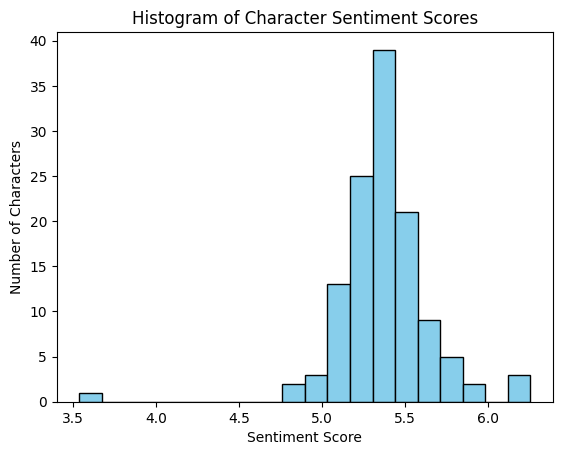

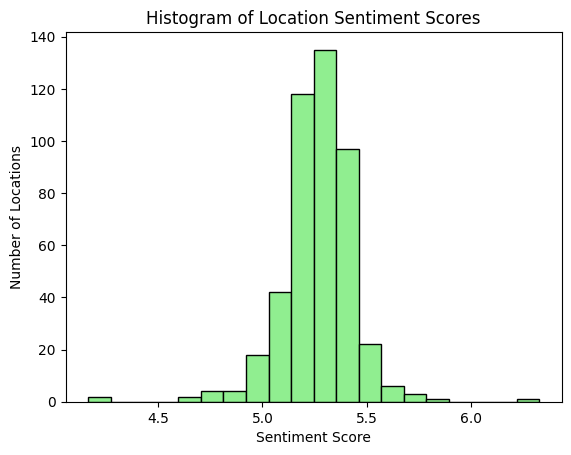

In [29]:
# plot histogram of character sentiment scores
import matplotlib.pyplot as plt

plt.hist(character_scores, bins=20, color="skyblue", edgecolor="black")
plt.title("Histogram of Character Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Number of Characters")
plt.show()
# plot histogram of location sentiment scores
plt.hist(location_scores, bins=20, color="lightgreen", edgecolor="black")
plt.title("Histogram of Location Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Number of Locations")
plt.show()

In [30]:
# print number of different locations
print(f"Total unique locations with dialogues: {len(location_dialogues)}")
# character dialogues
print(f"Total unique characters with dialogues: {len(character_dialogues)}")

Total unique locations with dialogues: 456
Total unique characters with dialogues: 137


In [31]:
# Character name normalization mapping
# Maps all variations of character names to canonical names
CHARACTER_NORMALIZATION = {
    # Luke
    "LUKE": "Luke Skywalker",
    "LUKE SKYWALKER": "Luke Skywalker",
    "LUKE'S VOICE": "Luke Skywalker",
    # Han Solo
    "HAN": "Han Solo",
    "HAN SOLO": "Han Solo",
    "HAN'S VOICE": "Han Solo",
    # Leia
    "LEIA": "Leia Organa",
    "LEIA ORGANA": "Leia Organa",
    "LEIA'S VOICE": "Leia Organa",
    "PRINCESS LEIA": "Leia Organa",
    # Obi-Wan
    "OBI-WAN": "Obi-Wan Kenobi",
    "OBI WAN": "Obi-Wan Kenobi",
    "OBI-WAN KENOBI": "Obi-Wan Kenobi",
    "BEN": "Obi-Wan Kenobi",
    "OLD BEN": "Obi-Wan Kenobi",
    # Yoda
    "YODA": "Yoda",
    "YODA'S VOICE": "Yoda",
    # Darth Vader
    "VADER": "Darth Vader",
    "DARTH VADER": "Darth Vader",
    "LORD VADER": "Darth Vader",
    "VADER'S VOICE": "Darth Vader",
    # Emperor Palpatine
    "EMPEROR": "Emperor Palpatine",
    "PALPATINE": "Emperor Palpatine",
    "EMPEROR PALPATINE": "Emperor Palpatine",
    "THE EMPEROR": "Emperor Palpatine",
    "EMPEROR'S VOICE": "Emperor Palpatine",
    # Lando
    "LANDO": "Lando Calrissian",
    "LANDO CALRISSIAN": "Lando Calrissian",
    # Chewbacca
    "CHEWBACCA": "Chewbacca",
    "CHEWIE": "Chewbacca",
    "CHEW": "Chewbacca",
    # C-3PO and R2-D2
    "C-3PO": "C-3PO",
    "C3PO": "C-3PO",
    "THREEPIO": "C-3PO",
    "THREE-PO": "C-3PO",
    "R2-D2": "R2-D2",
    "R2D2": "R2-D2",
    "ARTOO": "R2-D2",
    # Other characters
    "LEIA'S HANDMAIDEN": "Leia's Handmaiden",
    "REBEL GENERAL": "Rebel General",
    "IMPERIAL OFFICER": "Imperial Officer",
    "STORMTROOPER": "Stormtrooper",
    "GUARD": "Guard",
    "OFFICER": "Officer",
    "PILOT": "Pilot",
    "REBEL PILOT": "Rebel Pilot",
    "X-WING PILOT": "X-Wing Pilot",
    # Other named characters
    "WEDGE": "Wedge Antilles",
    "WEDGE ANTILLES": "Wedge Antilles",
    "UNCLE OWEN": "Owen Lars",
    "OWEN": "Owen Lars",
    "AUNT BERU": "Beru Lars",
    "BERU": "Beru Lars",
    "BIGGS": "Biggs Darklighter",
    "BIGGS DARKLIGHTER": "Biggs Darklighter",
    "TARKIN": "Grand Moff Tarkin",
    "GRAND MOFF TARKIN": "Grand Moff Tarkin",
    "MOFF TARKIN": "Grand Moff Tarkin",
    "LEA": "Leia Organa",
    "SCENE": "Scene",
    "VOICE": "Voice",
}


def normalize_character_name(name):
    """Normalize a character name to canonical form"""
    if not name or not isinstance(name, str):
        return None

    name_upper = name.upper().strip()

    # Remove common suffixes
    name_upper = re.sub(r"\s*\(V\.O\.\)\s*$", "", name_upper)
    name_upper = re.sub(r"\s*\(CONT\'D\)\s*$", "", name_upper)
    name_upper = re.sub(r"\s*O\.S\.\s*$", "", name_upper)

    if name_upper in CHARACTER_NORMALIZATION:
        return CHARACTER_NORMALIZATION[name_upper]

    # If not found, clean up the name and return it
    if (
        name_upper
        and len(name_upper) > 2
        and name_upper not in ["THE", "AND", "OR", "TO"]
    ):
        return name_upper.title()

    return None


# Test the normalization
print("Testing character name normalization:")
test_names = ["LUKE", "Han", "leia", "OBI-WAN KENOBI", "VADER", "C-3PO"]
for name in test_names:
    print(f"  {name} → {normalize_character_name(name)}")

Testing character name normalization:
  LUKE → Luke Skywalker
  Han → Han Solo
  leia → Leia Organa
  OBI-WAN KENOBI → Obi-Wan Kenobi
  VADER → Darth Vader
  C-3PO → C-3PO


In [32]:
# Location normalization mapping to merge redundant location names
LOCATION_NORMALIZATION = {
    "Darth Vader's Star Destroyer": "Vader's Star Destroyer",
    "Imperial Stardestroyer": "Imperial Star Destroyer",
    "Luke's X-Wing Fighter": "Luke's X-Wing",
    "Main Hangar Deck": "Main Hangar",
    "Red Ten's Cockpit.": "Red Ten's Cockpit",
    "Sail Barge Observation Deck": "Sail Barge",
    "Snowspeeder Cockpit": "Snowspeeder",
    "Stolen Imperial Shuttle": "Imperial Shuttle",
    "Tatooine Sea": "Tatooine",
    "Red Leader's X-Wing": "Red Leader Starship",
    "Red Leader's Cockpit": "Red Leader Starship",
    "Red Leader's Fighter": "Red Leader Starship",
    "Read Leader's Cockpit": "Red Leader Starship",
    "Read Leader's X-Wing Fighter": "Red Leader Starship",
}


def clean_location_name(location):
    """Clean and normalize location names from scene headings"""
    if not location:
        return None

    # Remove scene number prefix (Return of the Jedi format: "3    INT DEATH STAR")
    location = re.sub(r"^[0-9]+\s+", "", location).strip()

    # Remove INT/EXT prefix (if present) and time of day
    # Use optional match since some scenes like "SPACE" don't have INT/EXT
    location = re.sub(r"^(INT|EXT)[\.\s]+", "", location, flags=re.IGNORECASE).strip()
    location = re.sub(
        r"\s+[--]\s+(DAY|NIGHT|DAWN|DUSK|CONTINUOUS)$",
        "",
        location,
        flags=re.IGNORECASE,
    )

    # Remove details in parentheses
    location = re.sub(r"\s*\([^)]*\)\s*$", "", location)

    # Extract only the first part before the first dash to get the main location
    # e.g., "Asteroid Cave - Millennium Falcon - Cockpit" -> "Asteroid Cave"
    # e.g., "Death Star - Detention Area - Hallway" -> "Death Star"
    if " - " in location or " – " in location:
        location = re.split(r"\s+[-–]\s+", location)[0]

    # Clean up multiple spaces
    location = re.sub(r"\s+", " ", location).strip()

    # Convert to title case
    location = location.title()

    # Fix apostrophe capitalization issue (e.g., "Luke'S" -> "Luke's")
    location = re.sub(r"'S\b", "'s", location)

    # Apply location normalization mapping to merge redundant locations
    if location in LOCATION_NORMALIZATION:
        location = LOCATION_NORMALIZATION[location]

    return location if location else None


# Test location cleaning
print("Testing location name cleaning:")
test_locations = [
    "INT. LUKE'S HOUSE - LIVING ROOM - DAY",
    "EXT. DEATH STAR - OUTER SPACE - CONTINUOUS",
    "INT. MILLENNIUM FALCON - COCKPIT (MOVING) - NIGHT",
    "INT. ASTEROID CAVE - MILLENNIUM FALCON - COCKPIT",
    "INT. DEATH STAR - DETENTION AREA - HALLWAY",
    "INT. VADER'S STAR DESTROYER",
    "INT. DARTH VADER'S STAR DESTROYER",
    "EXT. IMPERIAL STAR DESTROYER",
    "EXT. IMPERIAL STARDESTROYER",
    "INT. LUKE'S X-WING",
    "INT. LUKE'S X-WING FIGHTER",
    "INT. MAIN HANGAR",
    "INT. MAIN HANGAR DECK",
    "1    SPACE",
    "19   HOLDING TUNNEL - RANCOR PIT",
    "3    INT DEATH STAR - CONTROL ROOM",
    "10   EXT TATOOINE - DESERT",
]
for loc in test_locations:
    print(f"  {loc}")
    print(f"    → {clean_location_name(loc)}\n")

Testing location name cleaning:
  INT. LUKE'S HOUSE - LIVING ROOM - DAY
    → Luke's House

  EXT. DEATH STAR - OUTER SPACE - CONTINUOUS
    → Death Star

  INT. MILLENNIUM FALCON - COCKPIT (MOVING) - NIGHT
    → Millennium Falcon

  INT. ASTEROID CAVE - MILLENNIUM FALCON - COCKPIT
    → Asteroid Cave

  INT. DEATH STAR - DETENTION AREA - HALLWAY
    → Death Star

  INT. VADER'S STAR DESTROYER
    → Vader's Star Destroyer

  INT. DARTH VADER'S STAR DESTROYER
    → Vader's Star Destroyer

  EXT. IMPERIAL STAR DESTROYER
    → Imperial Star Destroyer

  EXT. IMPERIAL STARDESTROYER
    → Imperial Star Destroyer

  INT. LUKE'S X-WING
    → Luke's X-Wing

  INT. LUKE'S X-WING FIGHTER
    → Luke's X-Wing

  INT. MAIN HANGAR
    → Main Hangar

  INT. MAIN HANGAR DECK
    → Main Hangar

  1    SPACE
    → Space

  19   HOLDING TUNNEL - RANCOR PIT
    → Holding Tunnel

  3    INT DEATH STAR - CONTROL ROOM
    → Death Star

  10   EXT TATOOINE - DESERT
    → Tatooine



In [33]:
print("all_scenes dialogues plus descriptions: ", all_scenes)

all_scenes dialogues plus descriptions:  {'A New Hope': [{'location': 'INT. REBEL BLOCKADE RUNNER - MAIN PASSAGEWAY', 'characters': {'THREEPIO'}, 'content': [('SCENE_DESCRIPTION', 'An explosion rocks the ship as two robots, Artoo-Detoo (R2-'), ('DIALOGUE', 'D2) and See-Threepio (C-3PO) struggle to make their way'), ('DIALOGUE', 'through the shaking, bouncing passageway. Both robots are'), ('DIALOGUE', 'old and battered. Artoo is a short, claw-armed tripod. His'), ('DIALOGUE', 'face is a mass of computer lights surrounding a radar eye.'), ('DIALOGUE', 'Threepio, on the other hand, is a tall, slender robot of'), ('DIALOGUE', 'human proportions. He has a gleaming bronze-like metallic'), ('DIALOGUE', 'surface of an Art Deco design.'), ('DIALOGUE', 'Another blast shakes them as they struggle along their way.'), ('CHARACTER', 'THREEPIO'), ('DIALOGUE', "Did you hear that? They've shut down"), ('DIALOGUE', "the main reactor. We'll be destroyed"), ('DIALOGUE', 'for sure. This is madness!'), ('D

In [34]:
from collections import defaultdict

# Process all scenes to build networks
character_connections = defaultdict(lambda: defaultdict(int))
# location_characters = defaultdict(set)
location_characters = defaultdict(lambda: defaultdict(int))
total_scenes = 0
skipped_scenes = 0
scenes_for_char_network = 0

# Track dialogue for sentiment analysis with normalized names
normalized_character_dialogues = defaultdict(list)
normalized_location_dialogues = defaultdict(list)

for movie_title, scenes in all_scenes.items():
    print(f"\nProcessing {movie_title}...")
    for scene in scenes:
        total_scenes += 1
        location = clean_location_name(scene["location"])
        if not location:
            skipped_scenes += 1
            continue

        # Normalize all character names in this scene
        normalized_chars = set()
        for char in scene["characters"]:
            normalized = normalize_character_name(char)
            if normalized:
                normalized_chars.add(normalized)

        # Skip scenes with no characters
        if len(normalized_chars) == 0:
            skipped_scenes += 1
            continue

        # Extract dialogue from scene content
        scene_dialogues = [
            text
            for content_type, text in scene["content"]
            if content_type == "DIALOGUE"
        ]

        # Add dialogue to normalized location
        normalized_location_dialogues[location].extend(scene_dialogues)

        # Add dialogue to all normalized characters in this scene
        for char in normalized_chars:
            normalized_character_dialogues[char].extend(scene_dialogues)

        # Add characters to location (even if only 1 character)
        for char in normalized_chars:
            # location_characters[location].add(char)
            location_characters[location][char] += 1

        # Create character-to-character connections only if 2+ characters
        if len(normalized_chars) >= 2:
            scenes_for_char_network += 1
            char_list = list(normalized_chars)
            for i in range(len(char_list)):
                for j in range(i + 1, len(char_list)):
                    char1 = char_list[i]
                    char2 = char_list[j]
                    # Store bidirectional connections
                    character_connections[char1][char2] += 1
                    character_connections[char2][char1] += 1


# NORMALIZE global_character_sentiments and global_location_sentiments SCORES BASED ON NORMALIZED NAMES
updated = {}
for original_name, sentiment in global_character_sentiments.items():
    normalized_name = normalize_character_name(original_name)
    updated[normalized_name] = sentiment

global_character_sentiments = updated

# Normalize location sentiments
updated = {}
for original_name, sentiment in global_location_sentiments.items():
    normalized_name = clean_location_name(original_name)
    updated[normalized_name] = sentiment
global_location_sentiments = updated

normalized_character_sentiments = {}
for character, dialogues in normalized_character_dialogues.items():

    sentiment = (
        global_character_sentiments.get(character)
        or global_character_sentiments.get(character.upper())
        or global_character_sentiments.get(character.title())
        or None
    )

    normalized_character_sentiments[character] = sentiment


normalized_location_sentiments = {}
for location, dialogues in normalized_location_dialogues.items():

    sentiment = (
        global_location_sentiments.get(location)
        or global_location_sentiments.get(location.upper())
        or global_location_sentiments.get(location.title())
        or None
    )

    normalized_location_sentiments[location] = sentiment


print(f"Calculated sentiments for {len(normalized_character_sentiments)} characters")
print(f"Calculated sentiments for {len(normalized_location_sentiments)} locations")

# Show summary statistics
print("\nTop 5 most connected characters:")
char_degrees = {
    char: len(connections) for char, connections in character_connections.items()
}
for char, degree in sorted(char_degrees.items(), key=lambda x: x[1], reverse=True)[:5]:
    sentiment = normalized_character_sentiments.get(char)
    sentiment_str = f"{sentiment:.3f}" if sentiment else "N/A"
    print(f"  {char}: {degree} connections (sentiment: {sentiment_str})")

print("\nTop 5 happiest characters:")
chars_with_sentiment = [
    (char, sentiment)
    for char, sentiment in normalized_character_sentiments.items()
    if sentiment is not None
]
for char, sentiment in sorted(chars_with_sentiment, key=lambda x: x[1], reverse=True)[
    :5
]:
    connections = len(character_connections.get(char, {}))
    print(f"  {char}: {sentiment:.3f} (connections: {connections})")

print("\nTop 5 saddest characters:")
for char, sentiment in sorted(chars_with_sentiment, key=lambda x: x[1])[:5]:
    connections = len(character_connections.get(char, {}))
    print(f"  {char}: {sentiment:.3f} (connections: {connections})")

print("\nTop 5 happiest locations:")
locs_with_sentiment = [
    (loc, sentiment)
    for loc, sentiment in normalized_location_sentiments.items()
    if sentiment is not None
]
for loc, sentiment in sorted(locs_with_sentiment, key=lambda x: x[1], reverse=True)[:5]:
    num_chars = len(location_characters.get(loc, set()))
    print(f"  {loc[:60]}: {sentiment:.3f} ({num_chars} characters)")

print("\nTop 5 saddest locations:")
for loc, sentiment in sorted(locs_with_sentiment, key=lambda x: x[1])[:5]:
    num_chars = len(location_characters.get(loc, set()))
    print(f"  {loc[:60]}: {sentiment:.3f} ({num_chars} characters)")


Processing A New Hope...

Processing The Empire Strikes Back...

Processing Return of the Jedi...
Calculated sentiments for 134 characters
Calculated sentiments for 94 locations

Top 5 most connected characters:
  Luke Skywalker: 48 connections (sentiment: 5.462)
  C-3PO: 46 connections (sentiment: 5.322)
  Leia Organa: 34 connections (sentiment: 5.334)
  Han Solo: 34 connections (sentiment: 5.682)
  Darth Vader: 33 connections (sentiment: 5.300)

Top 5 happiest characters:
  Strange Voice: 6.253 (connections: 3)
  Green Leader: 6.173 (connections: 3)
  Imperial Soldier: 6.150 (connections: 2)
  Trooper Voice: 5.913 (connections: 1)
  Voice Over Death Star Intercom: 5.891 (connections: 0)

Top 5 saddest characters:
  Deak: 3.540 (connections: 4)
  Second Threepio: 4.810 (connections: 3)
  Bunker Commander: 4.825 (connections: 4)
  Second Trooper: 4.907 (connections: 2)
  Second Officer: 4.937 (connections: 4)

Top 5 happiest locations:
  Millennium Falcon: 6.324 (17 characters)
  Gold

In [35]:
print(normalized_character_sentiments)
# min max and avg
scores = [s for s in normalized_character_sentiments.values() if s is not None]
if scores:
    print("\nNormalized character sentiment stats:")
    print(f"  Min: {min(scores)}")
    print(f"  Max: {max(scores)}")
    print(f"  Avg: {np.mean(scores):.4f}")
else:
    print("\nNo normalized character sentiment scores available.")
# print chars with no sentiment score
no_sentiment_chars = [
    char for char, score in normalized_character_sentiments.items() if score is None
]
print(f"Characters with no sentiment score: {no_sentiment_chars}")

# print null sentiments from character_scores = [s for s in global_character_sentiments.values() if s is not None]
character_scores = [s for s in global_character_sentiments.values() if s is not None]
null_sentiment_chars = [
    char for char, score in global_character_sentiments.items() if score is None
]
print(f"Characters with null sentiment scores: {null_sentiment_chars}")

{'C-3PO': 5.321874638936999, 'Luke Skywalker': 5.4622222222222225, 'Darth Vader': 5.299837712519305, 'Rebel Officer': 5.202222222222222, 'Imperial Officer': 5.252682926829269, 'Trooper': 5.280450000000006, 'Captain': 5.441333333333333, 'Chief Pilot': 5.1866666666666665, 'Woman': 5.506666666666667, 'Biggs Darklighter': 5.391861471861468, 'Fixer': 5.2829999999999995, 'Deak': 3.54, 'Camie': 5.2924999999999995, 'Day': 5.108000000000001, 'Leia Organa': 5.3341254858411675, 'Second Officer': 4.937333333333332, 'Commander': 5.128452380952384, 'Second Trooper': 4.906666666666666, 'First Trooper': 5.075238095238096, 'Beru Lars': 5.4295652173913025, 'Owen Lars': 5.342000000000005, 'Obi-Wan Kenobi': 5.312527392257098, 'Motti': 5.130632911392405, 'Grand Moff Tarkin': 5.366303630363041, 'Tagge': 5.211578947368425, 'Creature': 5.384849785407728, 'Bartender': 5.127217391304348, 'Human': 5.308181818181819, 'Han Solo': 5.682222222222221, 'Greedo': 5.381219512195125, 'Speeder Lot': 5.309565217391305, 'Ja

In [39]:
# Convert to regular dicts for JSON serialization and add sentiments
character_connections_dict = {}
for char, connections in character_connections.items():
    character_connections_dict[char] = {
        "connections": dict(connections),
        "sentiment": round(normalized_character_sentiments.get(char), 3) if normalized_character_sentiments.get(char) is not None else None,        
    }

location_characters_dict = {}
for location, characters in location_characters.items():
    location_characters_dict[location] = {
        "characters": dict(characters),
        "sentiment": round(normalized_location_sentiments.get(location), 3) if normalized_location_sentiments.get(location) is not None else None,
    }

# Save character connections to JSON
char_connections_path = DATA_DIR / "character_connections_with_sentiment.json"
with open(char_connections_path, "w") as f:
    json.dump(character_connections_dict, f, indent=2, sort_keys=True)
print(f"Saved character connections to {char_connections_path}")

# Save location-character connections to JSON
location_char_path = DATA_DIR / "location_characters_with_sentiment.json"
with open(location_char_path, "w") as f:
    json.dump(location_characters_dict, f, indent=2, sort_keys=True)
print(f"Saved location-character data to {location_char_path}")

# Verify the files were created
print(
    f"\nCharacter connections file size: {char_connections_path.stat().st_size} bytes"
)
print(f"Location-character file size: {location_char_path.stat().st_size} bytes")

# Show sample of character connections
print("\nSample character connections (Luke Skywalker):")
if "Luke Skywalker" in character_connections_dict:
    luke_data = character_connections_dict["Luke Skywalker"]
    luke_connections = luke_data["connections"]
    luke_sentiment = luke_data["sentiment"]

    print(
        f"  Sentiment score: {luke_sentiment:.3f}"
        if luke_sentiment
        else "  Sentiment score: N/A"
    )
    print(f"  Top connections:")
    for char, count in sorted(
        luke_connections.items(), key=lambda x: x[1], reverse=True
    )[:5]:
        print(f"    {char}: {count} scenes")
else:
    print("  Luke Skywalker not found in connections")

# Show sample of location data
print("\nSample locations:")
for location in sorted(location_characters_dict.keys())[:5]:
    location_data = location_characters_dict[location]
    chars = location_data["characters"]
    sentiment = location_data["sentiment"]

    sentiment_str = f"{sentiment:.3f}" if sentiment else "N/A"
    print(f"  {location}: {len(chars)} characters, sentiment: {sentiment_str}")

# Show top and bottom sentiment characters
print("\nTop 5 happiest characters:")
chars_with_sentiment = [
    (char, data["sentiment"])
    for char, data in character_connections_dict.items()
    if data["sentiment"] is not None
]
if chars_with_sentiment:
    for char, sentiment in sorted(
        chars_with_sentiment, key=lambda x: x[1], reverse=True
    )[:5]:
        print(f"  {char}: {sentiment:.3f}")

print("\nTop 5 saddest characters:")
if chars_with_sentiment:
    for char, sentiment in sorted(chars_with_sentiment, key=lambda x: x[1])[:5]:
        print(f"  {char}: {sentiment:.3f}")

# Show top and bottom sentiment locations
print("\nTop 5 happiest locations:")
locs_with_sentiment = [
    (loc, data["sentiment"])
    for loc, data in location_characters_dict.items()
    if data["sentiment"] is not None
]
if locs_with_sentiment:
    for loc, sentiment in sorted(locs_with_sentiment, key=lambda x: x[1], reverse=True)[
        :5
    ]:
        print(f"  {loc[:60]}...: {sentiment:.3f}")

print("\nTop 5 saddest locations:")
if locs_with_sentiment:
    for loc, sentiment in sorted(locs_with_sentiment, key=lambda x: x[1])[:5]:
        print(f"  {loc[:60]}...: {sentiment:.3f}")

Saved character connections to data/character_connections_with_sentiment.json
Saved location-character data to data/location_characters_with_sentiment.json

Character connections file size: 23930 bytes
Location-character file size: 16254 bytes

Sample character connections (Luke Skywalker):
  Sentiment score: 5.462
  Top connections:
    Han Solo: 43 scenes
    C-3PO: 29 scenes
    Leia Organa: 26 scenes
    Obi-Wan Kenobi: 22 scenes
    Darth Vader: 7 scenes

Sample locations:
  Another Cockpit: 2 characters, sentiment: 5.365
  Asteroid Cave: 3 characters, sentiment: 5.266
  Barge Observation Deck: 1 characters, sentiment: 5.469
  Battlefield: 2 characters, sentiment: 5.133
  Biggs' Cockpit: 3 characters, sentiment: 5.171

Top 5 happiest characters:
  Strange Voice: 6.253
  Green Leader: 6.173
  Imperial Soldier: 6.150
  Trooper Voice: 5.913
  First Officer: 5.833

Top 5 saddest characters:
  Deak: 3.540
  Second Threepio: 4.810
  Bunker Commander: 4.825
  Second Trooper: 4.907
  Seco

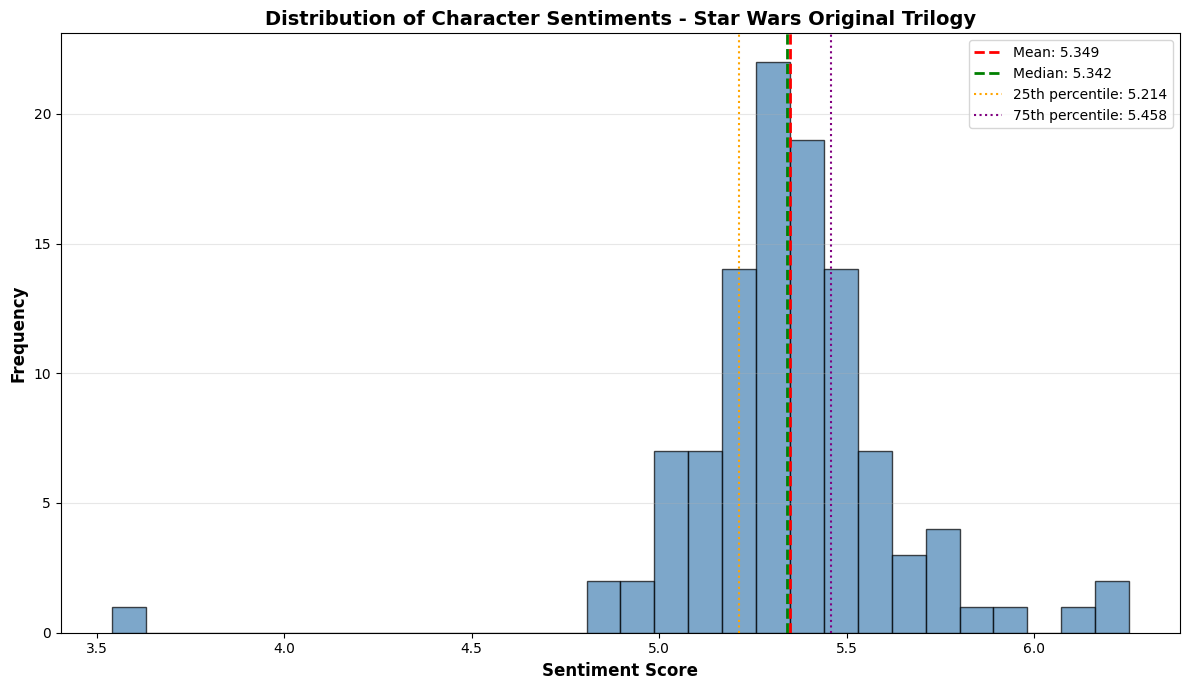


Character Sentiment Statistics:
  Total characters analyzed: 107
  Mean: 5.349
  Median: 5.342
  Std Dev: 0.302
  Min: 3.540
  Max: 6.253


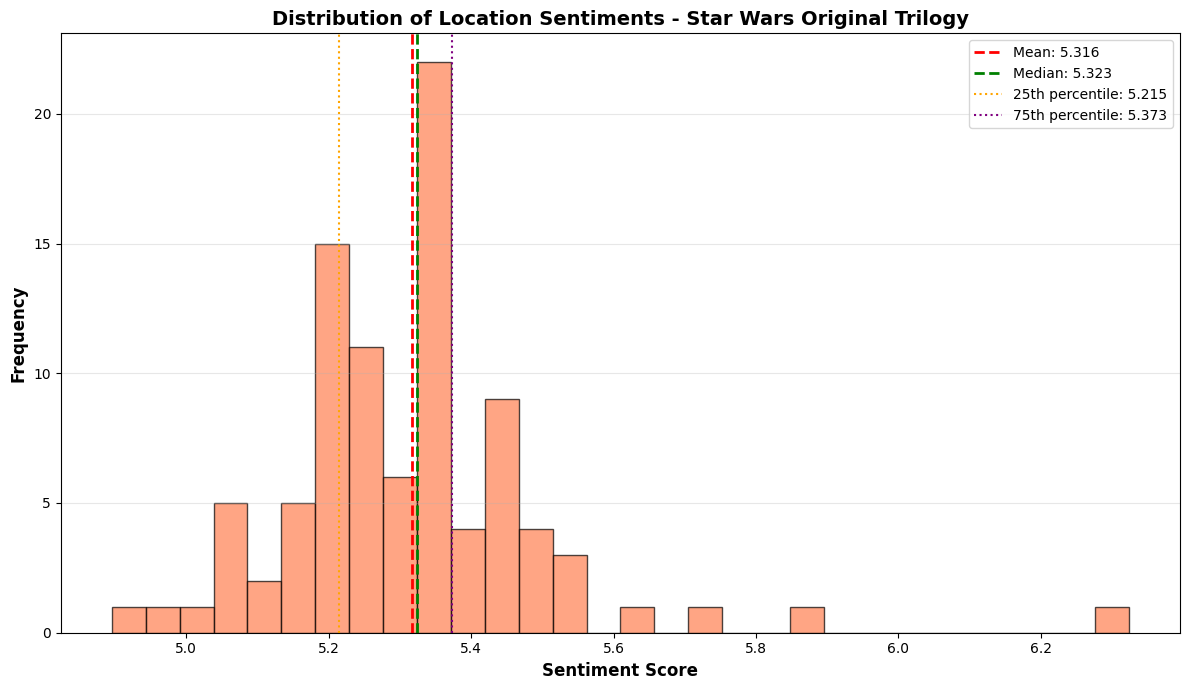


Location Sentiment Statistics:
  Total locations analyzed: 93
  Mean: 5.316
  Median: 5.323
  Std Dev: 0.183
  Min: 4.895
  Max: 6.324


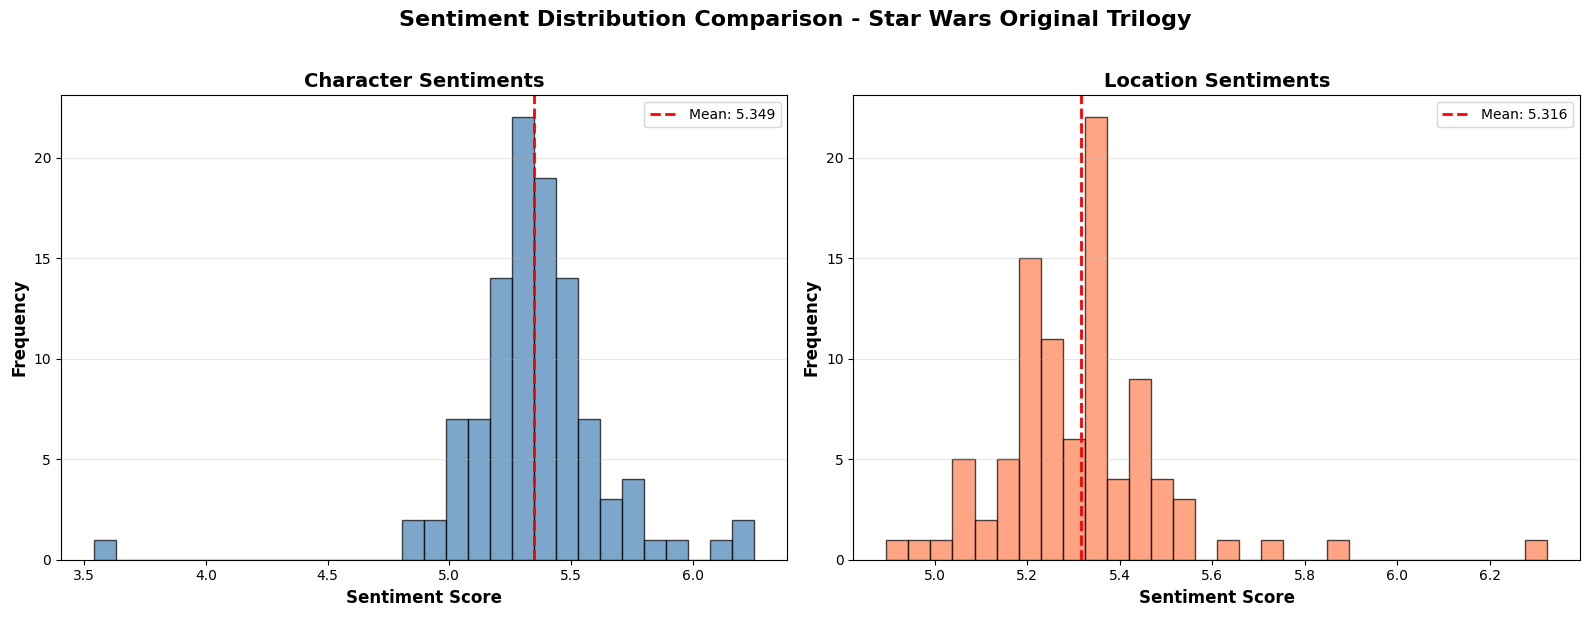

In [37]:
import numpy as np
import matplotlib.pyplot as plt

figures_dir = "./figures"
# Extract character sentiments (excluding None values)
character_sentiments = [
    data["sentiment"]
    for data in character_connections_dict.values()
    if data["sentiment"] is not None
]

# Extract location sentiments (excluding None values)
location_sentiments = [
    data["sentiment"]
    for data in location_characters_dict.values()
    if data["sentiment"] is not None
]

# Plot Character Sentiment Distribution
if character_sentiments:
    mean_sentiment = round(np.mean(character_sentiments), 4)
    median_sentiment = round(np.median(character_sentiments), 4)
    p25_sentiment = round(np.percentile(character_sentiments, 25), 4)
    p75_sentiment = round(np.percentile(character_sentiments, 75), 4)

    # Create figure and plot
    fig, ax = plt.subplots(figsize=(12, 7))

    # Histogram
    ax.hist(
        character_sentiments, bins=30, color="steelblue", edgecolor="black", alpha=0.7
    )

    # Add vertical lines for statistics
    ax.axvline(
        mean_sentiment,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {mean_sentiment:.3f}",
    )
    ax.axvline(
        median_sentiment,
        color="green",
        linestyle="--",
        linewidth=2,
        label=f"Median: {median_sentiment:.3f}",
    )
    ax.axvline(
        p25_sentiment,
        color="orange",
        linestyle=":",
        linewidth=1.5,
        label=f"25th percentile: {p25_sentiment:.3f}",
    )
    ax.axvline(
        p75_sentiment,
        color="purple",
        linestyle=":",
        linewidth=1.5,
        label=f"75th percentile: {p75_sentiment:.3f}",
    )

    # Labels and title
    ax.set_xlabel("Sentiment Score", fontsize=12, fontweight="bold")
    ax.set_ylabel("Frequency", fontsize=12, fontweight="bold")
    ax.set_title(
        "Distribution of Character Sentiments - Star Wars Original Trilogy",
        fontsize=14,
        fontweight="bold",
    )
    ax.legend(fontsize=10, loc="upper right")
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        figures_dir + "/character_sentiment_distribution.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    print(f"\nCharacter Sentiment Statistics:")
    print(f"  Total characters analyzed: {len(character_sentiments)}")
    print(f"  Mean: {mean_sentiment:.3f}")
    print(f"  Median: {median_sentiment:.3f}")
    print(f"  Std Dev: {np.std(character_sentiments):.3f}")
    print(f"  Min: {np.min(character_sentiments):.3f}")
    print(f"  Max: {np.max(character_sentiments):.3f}")

# Plot Location Sentiment Distribution
if location_sentiments:
    mean_sentiment = round(np.mean(location_sentiments), 4)
    median_sentiment = round(np.median(location_sentiments), 4)
    p25_sentiment = round(np.percentile(location_sentiments, 25), 4)
    p75_sentiment = round(np.percentile(location_sentiments, 75), 4)

    # Create figure and plot
    fig, ax = plt.subplots(figsize=(12, 7))

    # Histogram
    ax.hist(location_sentiments, bins=30, color="coral", edgecolor="black", alpha=0.7)

    # Add vertical lines for statistics
    ax.axvline(
        mean_sentiment,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {mean_sentiment:.3f}",
    )
    ax.axvline(
        median_sentiment,
        color="green",
        linestyle="--",
        linewidth=2,
        label=f"Median: {median_sentiment:.3f}",
    )
    ax.axvline(
        p25_sentiment,
        color="orange",
        linestyle=":",
        linewidth=1.5,
        label=f"25th percentile: {p25_sentiment:.3f}",
    )
    ax.axvline(
        p75_sentiment,
        color="purple",
        linestyle=":",
        linewidth=1.5,
        label=f"75th percentile: {p75_sentiment:.3f}",
    )

    # Labels and title
    ax.set_xlabel("Sentiment Score", fontsize=12, fontweight="bold")
    ax.set_ylabel("Frequency", fontsize=12, fontweight="bold")
    ax.set_title(
        "Distribution of Location Sentiments - Star Wars Original Trilogy",
        fontsize=14,
        fontweight="bold",
    )
    ax.legend(fontsize=10, loc="upper right")
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        figures_dir + "/location_sentiment_distribution.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    print(f"\nLocation Sentiment Statistics:")
    print(f"  Total locations analyzed: {len(location_sentiments)}")
    print(f"  Mean: {mean_sentiment:.3f}")
    print(f"  Median: {median_sentiment:.3f}")
    print(f"  Std Dev: {np.std(location_sentiments):.3f}")
    print(f"  Min: {np.min(location_sentiments):.3f}")
    print(f"  Max: {np.max(location_sentiments):.3f}")

# Optional: Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Character sentiments
if character_sentiments:
    axes[0].hist(
        character_sentiments, bins=30, color="steelblue", edgecolor="black", alpha=0.7
    )
    axes[0].axvline(
        np.mean(character_sentiments),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {np.mean(character_sentiments):.3f}",
    )
    axes[0].set_xlabel("Sentiment Score", fontsize=12, fontweight="bold")
    axes[0].set_ylabel("Frequency", fontsize=12, fontweight="bold")
    axes[0].set_title("Character Sentiments", fontsize=14, fontweight="bold")
    axes[0].legend(fontsize=10)
    axes[0].grid(axis="y", alpha=0.3)

# Location sentiments
if location_sentiments:
    axes[1].hist(
        location_sentiments, bins=30, color="coral", edgecolor="black", alpha=0.7
    )
    axes[1].axvline(
        np.mean(location_sentiments),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {np.mean(location_sentiments):.3f}",
    )
    axes[1].set_xlabel("Sentiment Score", fontsize=12, fontweight="bold")
    axes[1].set_ylabel("Frequency", fontsize=12, fontweight="bold")
    axes[1].set_title("Location Sentiments", fontsize=14, fontweight="bold")
    axes[1].legend(fontsize=10)
    axes[1].grid(axis="y", alpha=0.3)

plt.suptitle(
    "Sentiment Distribution Comparison - Star Wars Original Trilogy",
    fontsize=16,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig(figures_dir + "/sentiment_comparison.png", dpi=300, bbox_inches="tight")
plt.show()